In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import pathlib

In [2]:
# --- КРОК 1 & 2: Завантаження та підготовка даних ---

# Завантажуємо архів
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
zip_dir = tf.keras.utils.get_file("101_food_classes_10_percent.zip", origin=url, extract=False)

# Розпаковуємо (якщо ще не розпаковано)
base_dir = os.path.join(os.path.dirname(zip_dir), "101_food_classes_10_percent")
if not os.path.exists(base_dir):
    with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_dir))

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

1625420029/1625420029 ━━━━━━━━━━━━━━━━━━━━ 221s 0us/step


In [3]:
# --- ВИЗНАЧЕННЯ ІНДИВІДУАЛЬНИХ КЛАСІВ ---
# Отримуємо список всіх класів та сортуємо їх
all_classes = sorted([item for item in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, item))])

# Мій номер студента
n = 12

# Індекси згідно завдання
indices = [n-1, n+29, n+59] # [11, 41, 71]

# Вибираємо назви класів
my_classes = [all_classes[i] for i in indices]

print(f"Студент №{n}")
print(f"Обрані індекси: {indices}")
print(f"Обрані класи: {my_classes}")

Студент №12
Обрані індекси: [11, 41, 71]
Обрані класи: ['caesar_salad', 'french_onion_soup', 'paella']


In [4]:
# --- ЗАВАНТАЖЕННЯ ДАТАСЕТІВ (Тільки 3 класи) ---

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("\nЗавантаження тренувальних даних:")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    class_names=my_classes, # ВАЖЛИВО: завантажуємо тільки твої класи
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

print("\nЗавантаження тестових даних:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    class_names=my_classes,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Не перемішуємо тест для коректної оцінки confusion matrix (опціонально)
)


Завантаження тренувальних даних:
Found 225 files belonging to 3 classes.

Завантаження тестових даних:
Found 750 files belonging to 3 classes.


In [5]:
# --- КРОК 3: Побудова моделі CNN ---
# Додаємо шар Rescaling для нормалізації пікселів (0-255 -> 0-1)
# Це покращує збіжність мережі
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)), 
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax') # 3 нейрони, бо 3 класи
])

model.summary()

c:\Users\Anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# --- КРОК 4: Компіляція моделі ---
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# --- КРОК 5: Навчання моделі ---
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15  # Можна зменшити до 10, якщо модель швидко перенавчається
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 544ms/step - accuracy: 0.3156 - loss: 6.1753 - val_accuracy: 0.3413 - val_loss: 1.1295
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.3289 - loss: 1.1697 - val_accuracy: 0.4947 - val_loss: 1.0498
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.5467 - loss: 1.0057 - val_accuracy: 0.4733 - val_loss: 0.9863
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.6000 - loss: 0.8678 - val_accuracy: 0.5187 - val_loss: 0.9851
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.6311 - loss: 0.7844 - val_accuracy: 0.5453 - val_loss: 0.9438
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - accuracy: 0.7111 - loss: 0.7046 - val_accuracy: 0.5360 - val_loss: 0.9863
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.8356 - loss: 0.4935 - val_accuracy: 0.6733 - val_loss: 0.8100
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.9022 - loss: 0.3609 - val_accuracy: 0.6493 - val_loss:

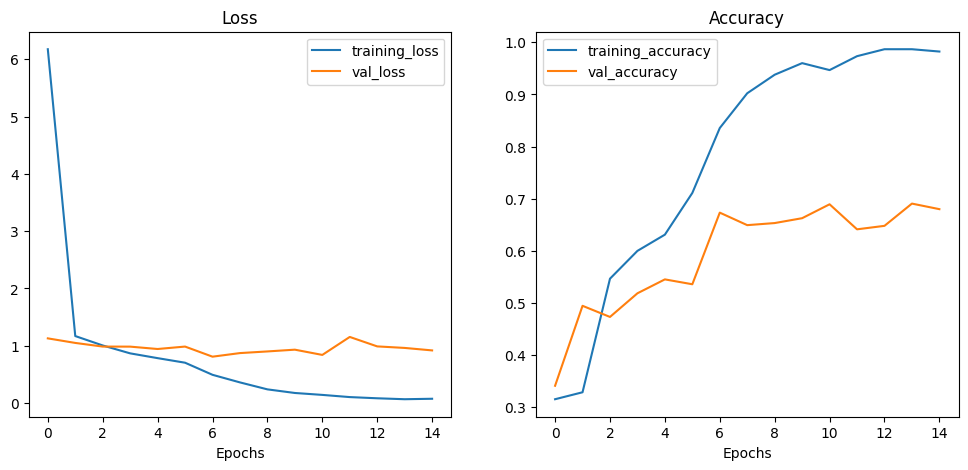

In [8]:
# --- КРОК 6: Аналіз результатів (Графіки) ---
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(12, 5))

    # Графік Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Графік Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()

plot_loss_curves(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6800 - loss: 0.9193

Test Accuracy: 68.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


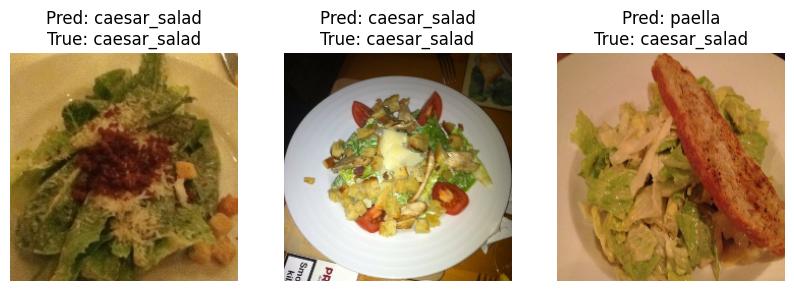

In [9]:
# --- КРОК 7: Оцінка та приклад передбачення ---
loss, acc = model.evaluate(test_data)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Приклад передбачення на одному батчі
images, labels = next(iter(test_data))
pred_probs = model.predict(images)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(labels, axis=1)

plt.figure(figsize=(10, 5))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    
    pred_label = my_classes[pred_classes[i]]
    true_label = my_classes[true_classes[i]]
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()